# Galaxies: An interactive graduate course

## Chapter 10: Subhalos, satellites, and mergers

#### (c) Benedikt Diemer, University of Maryland

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 10.1) Subhalos

The following function loads halos and subhalos according to different spatial selection criteria.

In [2]:
import h5py
from colossus.cosmology import cosmology
from colossus.halo import mass_so

cosmo = cosmology.setCosmology('bolshoi')

def loadHalos(sim_name, z = 0.0, min_n_ptl = 200, selection = None, 
             z_min = 0.4, z_max = 0.6, min_mass_ratio = None):
    
    # Open file and load simulation info
    fn = cmn.data_dir + 'nbody/tree_%s.hdf5' % (sim_name)
    f = h5py.File(fn, 'r')
    snap_z = f['simulation'].attrs['snap_z']
    L_box = f['simulation'].attrs['box_size']
    m_ptl = f['simulation'].attrs['particle_mass']
    M_min = m_ptl * min_n_ptl
    
    # Find closest snapshot
    snap_idx = np.argmin(np.abs(snap_z - z))
    z_used = snap_z[snap_idx]
    
    # Load mass and subhalo status
    x = np.array(f['x'][snap_idx, :])
    M = np.array(f['Mvir'][snap_idx, :])
    is_sub = np.array(f['is_subhalo'][snap_idx, :])
    f.close()
    
    # Cut out halos below particle limit and those outside the requested slab
    mask = (M >= M_min)
    
    # Spatially select particles
    x_ext = np.zeros((2, 3), float)
    x_ext[1, :] = L_box
    
    if selection == 'slice':
        mask &= (x[:, 2] >= z_min * L_box) & (x[:, 2] <= z_max * L_box)
        x_ext[0, 2] = z_min * L_box
        x_ext[1, 2] = z_max * L_box
        
    elif selection in ['most_massive', 'ratio']:
        
        if selection == 'most_massive':
            idx = np.argmax(M)
        else:
            target_M = M_min / min_mass_ratio
            idx = np.argmin(np.abs(M - target_M))
            if M[idx] / target_M < 0.5:
                print('Target halo mass could not be reached (%.1f, %.1f).' \
                      % (np.log10(target_M), np.log10(M[idx])))

        R = mass_so.M_to_R(M[idx], z, 'vir') / 1000.0
        ext = R * 2.0
        for i in range(3):
            x_ext[0, i] = x[idx, i] - ext
            x_ext[1, i] = x[idx, i] + ext
            mask &= (x[:, i] >= x_ext[0, i]) & (x[:, i] <= x_ext[1, i])
    
    elif selection is None:
        
        mask = np.ones_like(M, bool)
    
    else:
        raise Exception('Unknown selection.')
        
    x = x[mask, :]
    M = M[mask]
    is_sub = is_sub[mask]
    
    return x, M, is_sub, L_box, z_used, x_ext

In [3]:
def plotHalos(selection = None, save = False, fn_out = 'subhalos.pdf', **kwargs):

    sim_names = ['l0500-bol', 'l0250-bol', 'l0125-bol', 'l0063-bol']
    n_sims = len(sim_names)

    fig, axs = plt.subplots(2, 2, figsize = (10.0, 10.0))
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    axs = axs.flatten()

    for i in range(n_sims):

        x, M, is_sub, L, z_snap, x_ext = loadHalos(sim_names[i], selection = selection, **kwargs)
        R = mass_so.M_to_R(M, z_snap, 'vir') / 1000.0

        plt.sca(axs[i])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        for j in range(len(R)):
            circle = plt.Circle((x[j, 0], x[j, 1]), R[j], color = 'r', fill = False, linestyle = 'solid', lw = 0.4)
            if is_sub[j]:
                circle.set_color(cmn.color_cycle[1])
            else:
                circle.set_color(cmn.color_cycle[0])
            axs[i].add_artist(circle)
        plt.xlim(x_ext[0, 0], x_ext[1, 0])
        plt.ylim(x_ext[0, 1], x_ext[1, 1])
        
        if selection in ['most_massive', 'ratio']:
            txt = r'$\log_{10}\ M_{\rm vir} = %.1f$' % (np.log10(np.max(M)))
        else:
            txt = r'$L = %s\ {\rm Mpc}/h$' % (str(L))
        plt.text(0.05, 0.92, txt, transform = axs[i].transAxes, fontsize = 16)

    if save:
        plt.savefig(fn_out)
    else:
        plt.show()

#### Distribution of subhalos

Let's plot a thin slice through the box, distinguishing hosts and subhalos.

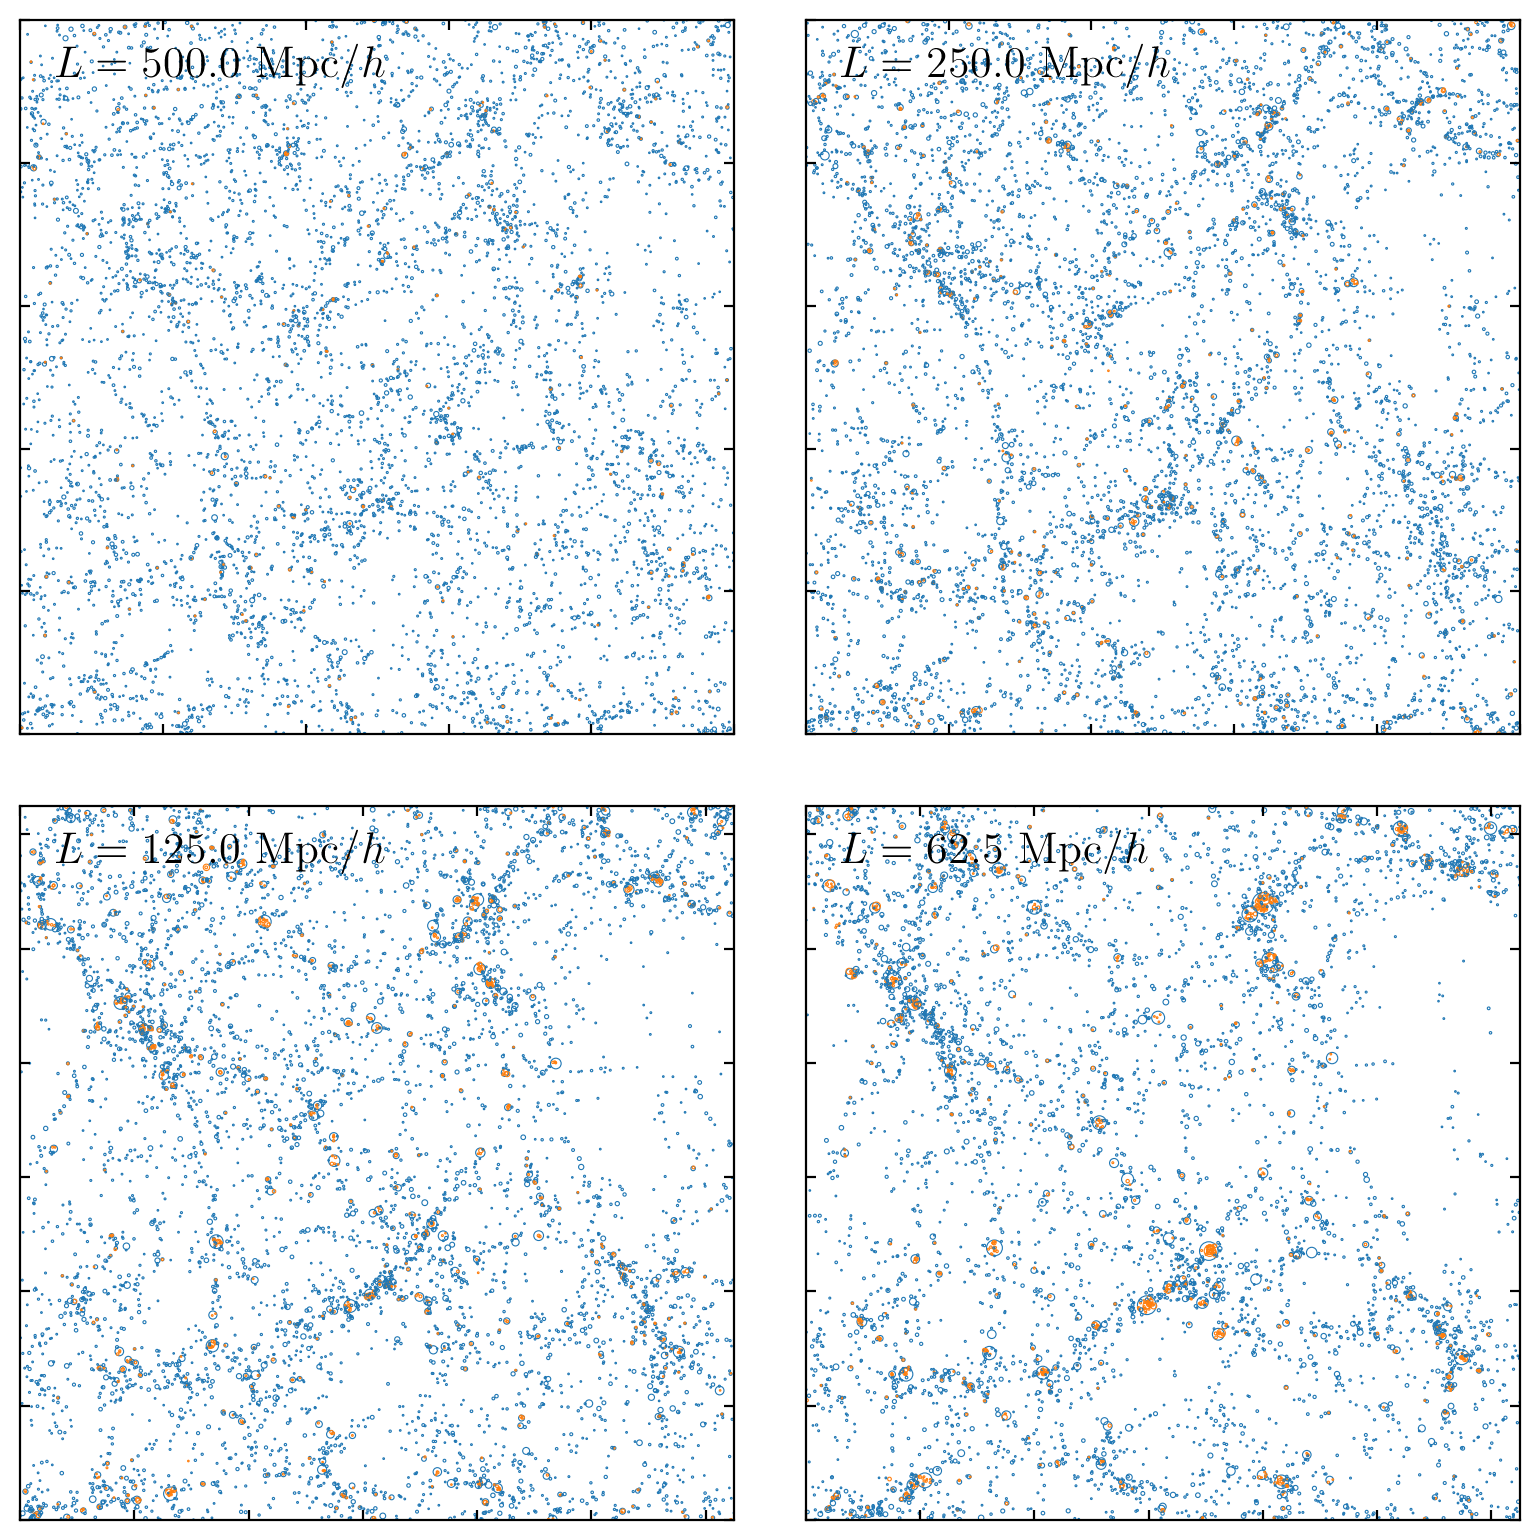

In [4]:
plotHalos(selection = 'slice', min_n_ptl = 2000, z_min = 0.4, z_max = 0.6)

The smaller boxes are noticeably more clustered. Since we are only selecting halos with 2000 or more particles, there aren't many subhalos that fulfil this limit in the larger boxes. Let's instead plot the most massive halos and their subhalos.

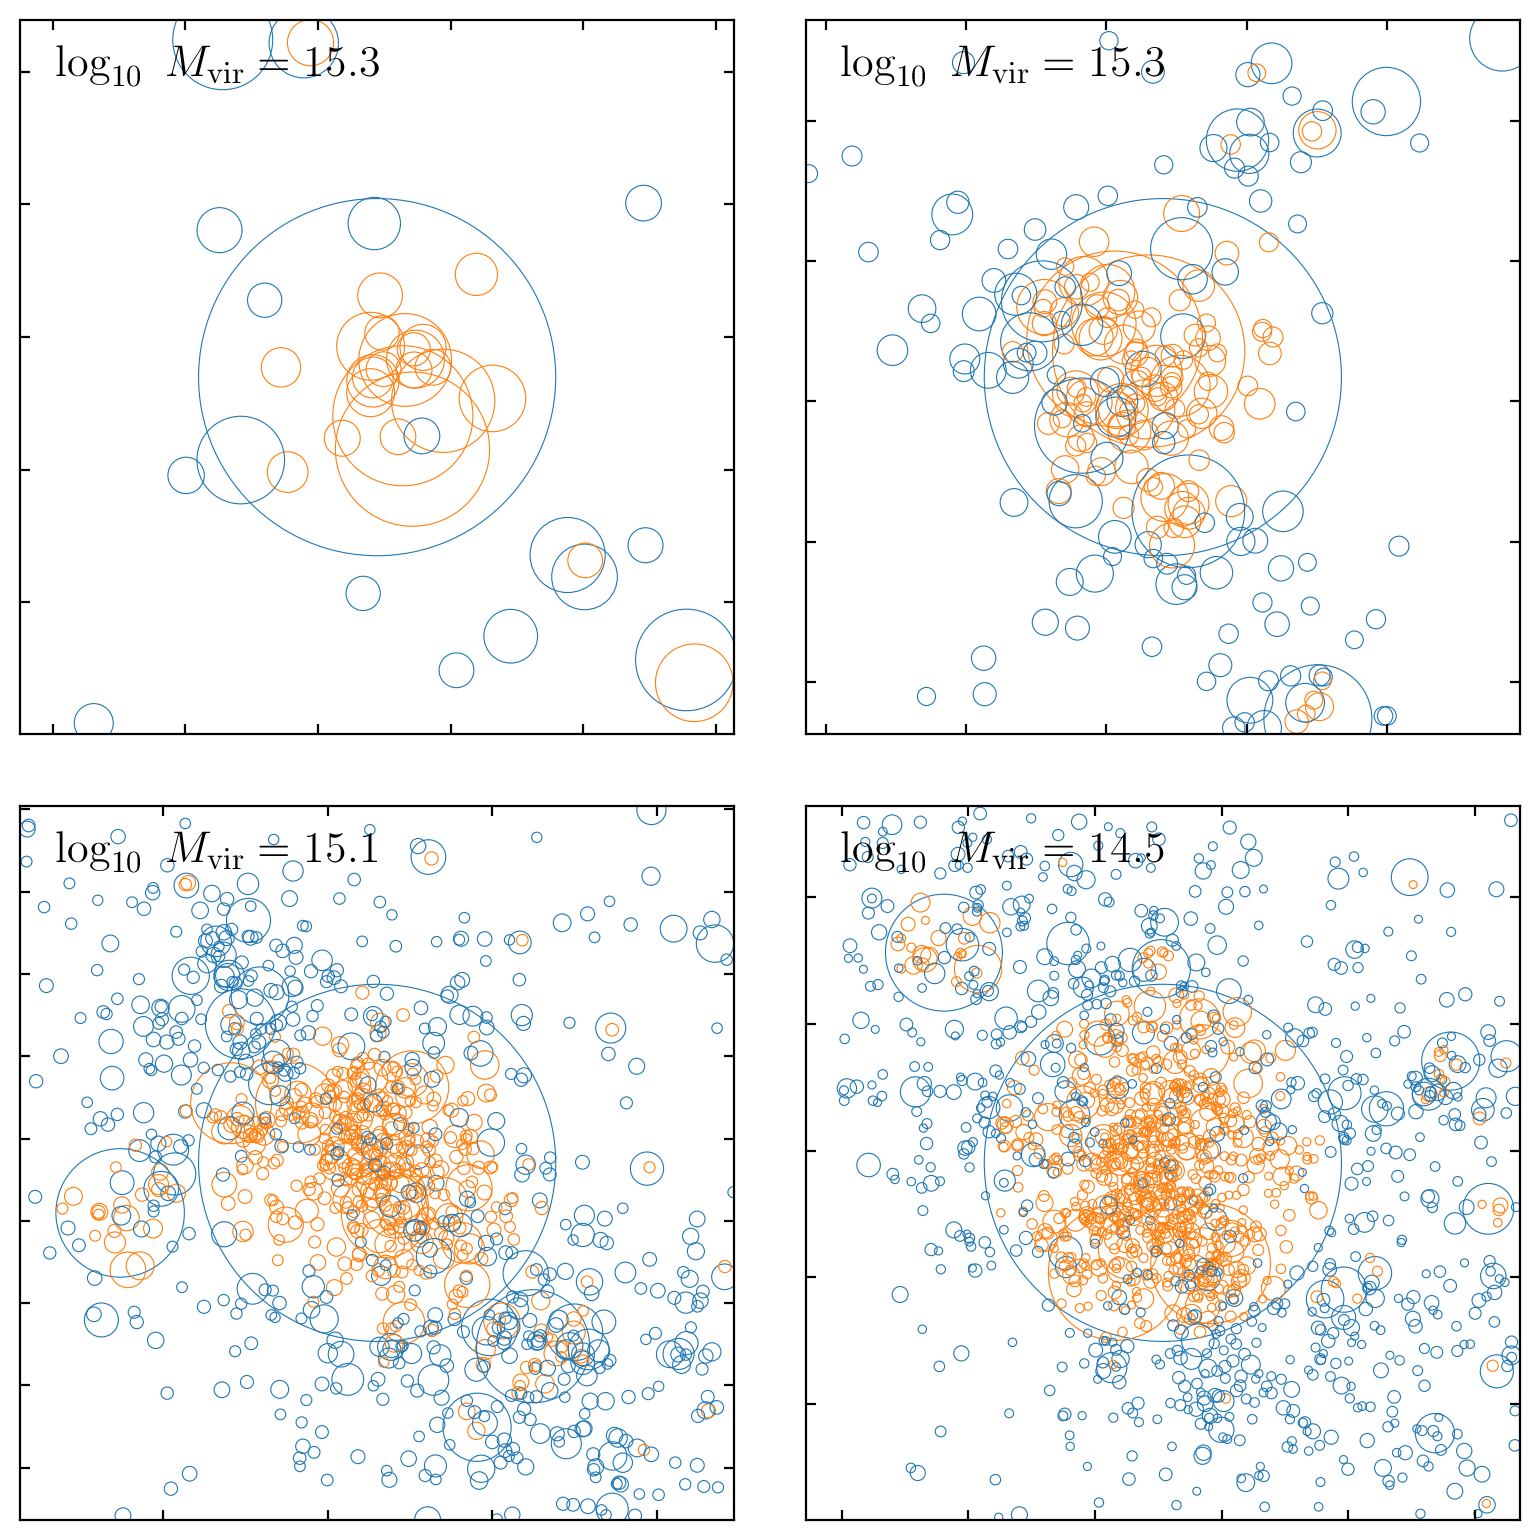

In [5]:
plotHalos(selection = 'most_massive', min_n_ptl = 200)

There are a lot fewer subhalos in the larger boxes, simply because they do not make the resolution cut. The halo masses do not decrease as much as the particle mass, so there are way more particles in the last halo. Instead, we can impose a fixed ratio between particle and halo mass.

Target halo mass could not be reached (15.9, 15.3).


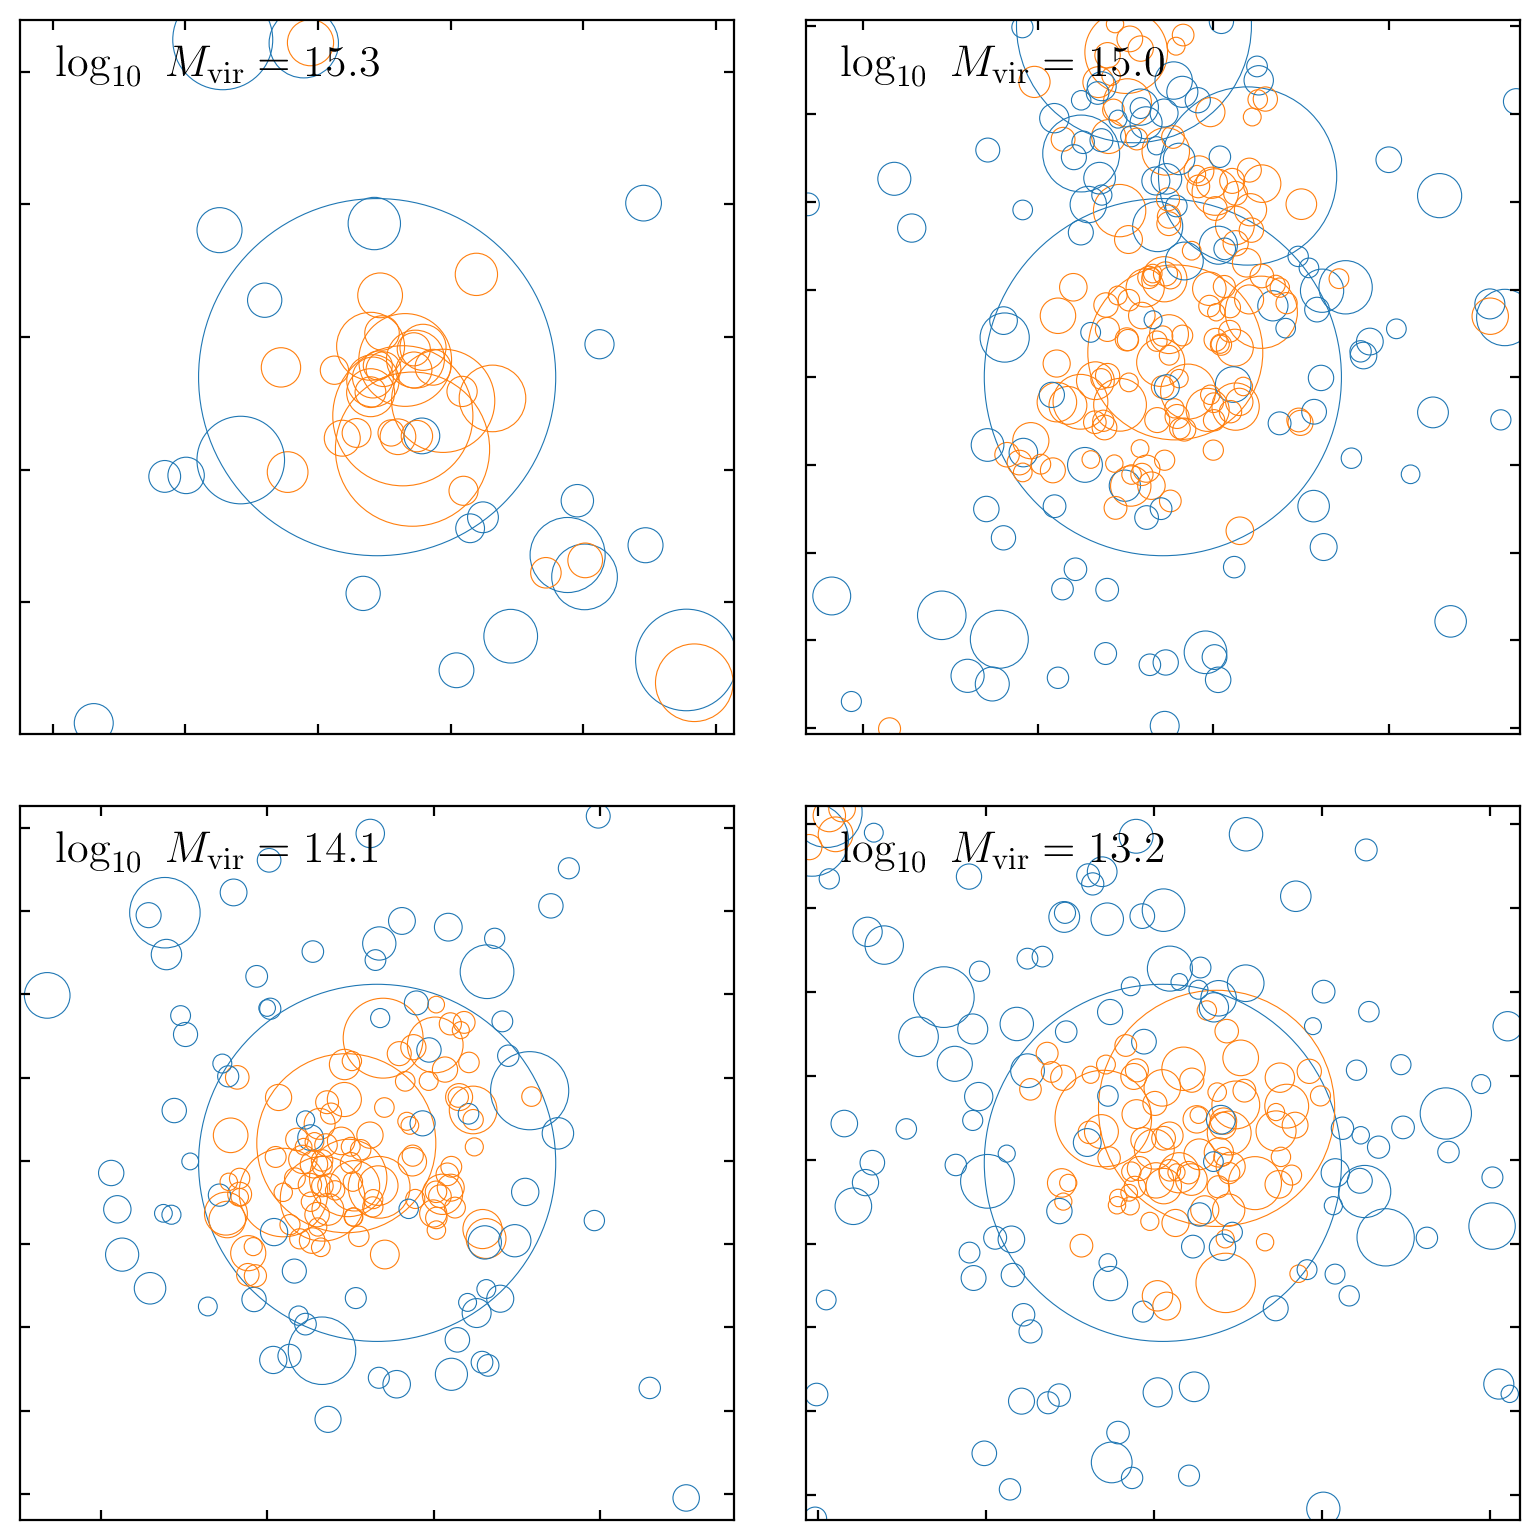

In [6]:
plotHalos(selection = 'ratio', min_n_ptl = 100, min_mass_ratio = 1E-4, save = False)

In the largest box, we are still limited by the resolution, and so we see fewer subhalos. But in the other boxes, the structure appears similar even though we are plotting vastly different halo masses.

#### The subhalo fraction as a function of halo mass

Let's plot the fraction of halos that are subhalos as a function of mass. We need to be careful with the resolution cut since subhalo disruption is strongly dependent on resolution.

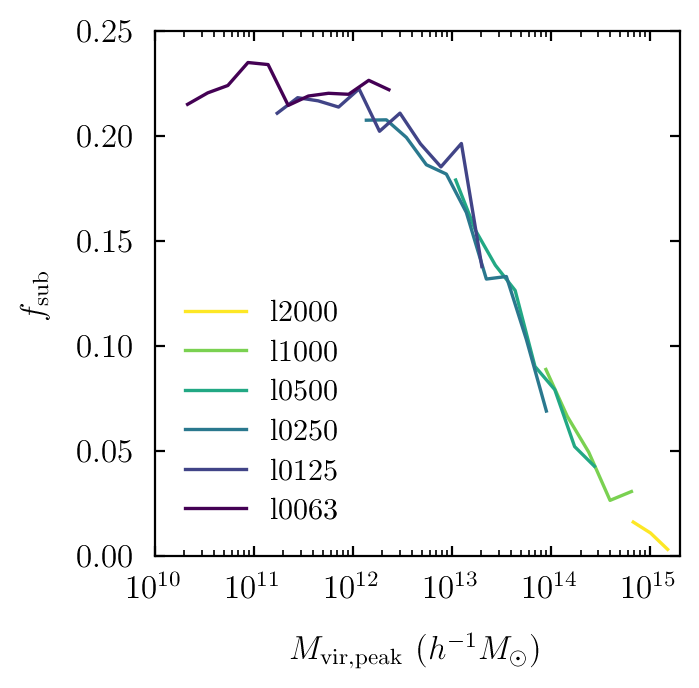

In [7]:
from matplotlib.ticker import LogLocator

def getSubhaloFraction(sim_name, z, min_n_ptl = 1000, n_bins_per_log = 5, n_min_in_bin = 200):
    
    # Open file and load simulation info
    fn = cmn.data_dir + 'nbody/tree_%s.hdf5' % (sim_name)
    f = h5py.File(fn, 'r')
    snap_z = f['simulation'].attrs['snap_z']
    m_ptl = f['simulation'].attrs['particle_mass']
    M_min = m_ptl * min_n_ptl
    
    # Find closest snapshot
    snap_idx = np.argmin(np.abs(snap_z - z))
    
    # Load mass and subhalo status
    M = np.array(f['Mvir'])
    is_sub = np.array(f['is_subhalo'][snap_idx, :])
    f.close()
    
    # Compute Mpeak, cut halos below particle limit
    Mpeak = np.max(M, axis = 0)
    mask = (Mpeak >= M_min)
    Mpeak = Mpeak[mask]
    is_sub = is_sub[mask]

    # Compute subhalo fraction
    log_M = np.log(Mpeak)
    n_bins = int((np.log10(np.max(Mpeak)) - np.log10(np.min(Mpeak))) * n_bins_per_log)
    n_bins = max(n_bins, 5)
    mf_all, bin_edges = np.histogram(log_M, bins = n_bins)
    mf_sub, bin_edges = np.histogram(log_M[is_sub], bins = bin_edges)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    mask = (mf_all > n_min_in_bin)
    sub_frac = mf_sub[mask] / mf_all[mask]

    bin_edges_log = np.log10(np.exp(bin_edges))
    bin_centers_log = 0.5 * (bin_edges_log[1:] + bin_edges_log[:-1])
    bin_centers = 10**bin_centers_log
    
    return sub_frac, bin_centers[mask]

cosmo = cosmology.setCosmology('bolshoi')
sim_names = ['l2000-bol', 'l1000-bol', 'l0500-bol', 'l0250-bol', 'l0125-bol', 'l0063-bol']
z = 0.0
cmap = plt.get_cmap('viridis_r')

# Prepare plot
fig = plt.figure(figsize = (3.5, 3.5))
ax = plt.gca()
plt.xscale('log')
plt.xlim(1E10, 2E15)
plt.ylim(0.0, 0.25)
plt.xlabel(r'$M_{\rm vir,peak}\ (h^{-1} M_\odot)$')
plt.ylabel(r'$f_{\rm sub}$')
ax.xaxis.set_major_locator(LogLocator(numticks = 100))
ax.xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i, sn in enumerate(sim_names):
    c = cmap(float(i) / (len(sim_names) - 1.0))
    sub_frac, bin_centers = getSubhaloFraction(sn, z)
    plt.plot(bin_centers, sub_frac, c = c, lw = 1.2, label = r'$\mathrm{%s}$' % sn[:-4])

plt.legend()
plt.show()

As expected, small halos are more likely to be subhalos. At the largest halo masses, $f_{\rm sub}$ must go to zero since there are no larger hosts. We note that the normalization of $f_{\rm sub}$ would be different if we chose a different radius definition than $R_{\rm vir}$.